In [1]:
import pandas as pd

nixpkgs_graph = pd.read_csv("nodes.csv")
nixpkgs_graph.describe()

,timeset,indegree,outdegree,Degree
count,0.0,46378.000000,46378.000000,46378.000000
mean,NaN,6.678404,6.678404,13.356807
std,NaN,336.433605,18.098570,337.023105
min,NaN,0.000000,0.000000,1.000000
25%,NaN,1.000000,4.000000,5.000000
50%,NaN,1.000000,4.000000,6.000000
75%,NaN,2.000000,7.000000,9.000000
max,NaN,46275.000000,3203.000000,46301.000000


In [68]:
degree_distribution = nixpkgs_graph.groupby("Degree").size()
in_degree_distribution = nixpkgs_graph.groupby("indegree").size()
out_degree_distribution = nixpkgs_graph.groupby("outdegree").size()

df1 = degree_distribution.to_frame('Average').cumsum()
df2 = in_degree_distribution.to_frame('In').cumsum()
df3 = out_degree_distribution.to_frame('Out').cumsum()

df1 = df1.max() - df1
df2 = df2.max() - df2
df3 = df3.max() - df3

df = pd.concat([df1, df2, df3], axis=1)
df["degree"] = df.index
df = pd.melt(df, id_vars=["degree"], value_vars=["In", "Out"], var_name="degree type", value_name="number of nodes > degree")
df.groupby("degree type").describe()

degree                                                     \
             count         mean          std  min   25%    50%    75%   
degree type                                                             
In           355.0  1219.171831  5310.339551  0.0  88.5  200.0  447.5   
Out          355.0  1219.171831  5310.339551  0.0  88.5  200.0  447.5   

                     number of nodes > degree                                 \
                 max                    count         mean          std  min   
degree type                                                                    
In           46301.0                    223.0   523.587444  2634.872154  0.0   
Out          46301.0                    134.0  2251.320896  8055.796771  0.0   

                                           
               25%    50%    75%      max  
degree type                                
In           59.50  131.0  265.0  36334.0  
Out          34.25   77.0  321.0  46319.0

In [71]:
# regression in log-log
import numpy as np
degrees = df2.index
fit_range = (degrees > 0) & (degrees < 1e3)
log_vals = np.log(df2[fit_range]["In"])
log_degrees = np.log(degrees[fit_range])
A = np.vstack([log_degrees, np.ones(len(log_degrees))]).T
((k2, c2), _, _, _) = np.linalg.lstsq(A, log_vals, rcond=None)

degrees = df3.index
fit_range = (degrees > 4) & (degrees < 1e3)
log_vals = np.log(df3[fit_range]["Out"])
log_degrees = np.log(degrees[fit_range])
A = np.vstack([log_degrees, np.ones(len(log_degrees))]).T
((k3, c3), _, _, _) = np.linalg.lstsq(A, log_vals, rcond=None)

print('exponent-in:', k2)
print('constant-in:', c2)
print('exponent-out:', k3)
print('constant-out:', c3)

exponent-in: -0.9078836427195877
constant-in: 9.2858790949897
exponent-out: -1.8837170250023647
constant-out: 12.514194073898029


Text(0.95, 0.9, 'exponent = -1.88')

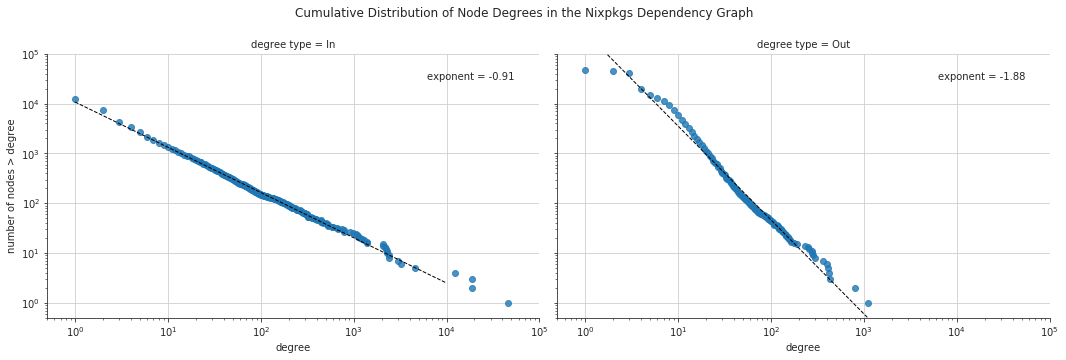

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
%matplotlib inline

# basic plot
g = sns.lmplot(x="degree", y="number of nodes > degree", col="degree type",
               truncate=True, height=5, aspect=1.5, data=df, fit_reg=False)
g.set(xscale="log", yscale="log", xlim=(0.5, 1e5), ylim=(0.5, 1e5))
sns.despine()
g.fig.suptitle("Cumulative Distribution of Node Degrees in the Nixpkgs Dependency Graph")
g.fig.subplots_adjust(top=.85)

g.axes[0,0].plot(np.linspace(1, 1e4, 2), np.exp(c2)*np.linspace(1, 1e4, 2)**k2, '--', c='black', lw=1, zorder=1)
g.axes[0,0].text(0.95, 0.9, "exponent = {:2.2f}".format(k2), ha="right", transform=g.axes[0,0].transAxes)
g.axes[0,1].plot(np.linspace(1, 1e4, 2), np.exp(c3)*np.linspace(1, 1e4, 2)**k3, '--', c='black', lw=1, zorder=1)
g.axes[0,1].text(0.95, 0.9, "exponent = {:2.2f}".format(k3), ha="right", transform=g.axes[0,1].transAxes)